<a href="https://colab.research.google.com/github/essymizo/GIS_MachineLearning/blob/main/Machine_Learning_for_Satellite_Image_Classification_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Satellite Image Classification with Python

In this tutorial we shall see how to perform unsupervised and supervised image classification using scikit-learn library of Python.

First let us install the required Python libraries.

In [ ]:
!pip install pandas gdal geopandas scikit-learn

Now, let us download the data and unpack it. There are 2 files:

1. LISS-3 image (4 bands) of Panshet, near Pune, Maharashtra; and
2. Landcover data of the same area.


In [ ]:
!wget --cookies=on --keep-session-cookies --no-check-certificate -m "https://iirsgovin-my.sharepoint.com/:u:/g/personal/prasun_iirsddn_ac_in/EUsl7112cLhOiqDgDtEZjhsBALYTM_Ao24wiF0SSOLVSNw?e=iB9D2N&download=1" --output-document=data.zip

will be placed in the single file you specified.

for details.

--2024-01-26 15:37:06--  https://iirsgovin-my.sharepoint.com/:u:/g/personal/prasun_iirsddn_ac_in/EUsl7112cLhOiqDgDtEZjhsBALYTM_Ao24wiF0SSOLVSNw?e=iB9D2N&download=1
Resolving iirsgovin-my.sharepoint.com (iirsgovin-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to iirsgovin-my.sharepoint.com (iirsgovin-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/prasun_iirsddn_ac_in/Documents/isg-isrs-2023-pune-pre-sym-tutorial/data2.zip?ga=1 [following]
--2024-01-26 15:37:06--  https://iirsgovin-my.sharepoint.com/personal/prasun_iirsddn_ac_in/Documents/isg-isrs-2023-pune-pre-sym-tutorial/data2.zip?ga=1
Reusing existing connection to iirsgovin-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 521463 (509K) [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip            100%[================

In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: landcover.tif.aux.xml   
  inflating: liss3-panshet.tif       
  inflating: liss3-panshet.tif.aux.xml  
  inflating: landcover.tif           


Importing Python libraries

In [ ]:
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

Let us display a false color composite (fcc) of the LISS-3 image.

(4, 384, 444)


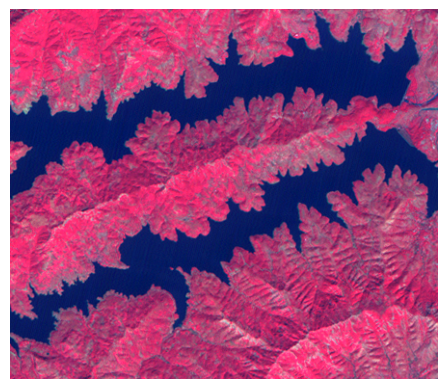

In [ ]:
# displaying the LISS 3 image used in this exercise
l3 = gdal.Open('liss3-panshet.tif').ReadAsArray()
print(l3.shape)

#showing fcc of the image
plt.axis('off')
fcc = l3[[2,1,0],:,:] # select 3 bands to make fcc
fcc1 = np.interp(fcc, (10, 80), (0, 1)) # histogram stretching
fcc2 = np.moveaxis(fcc1,0,-1) # shifting axis as imshow function requires data in (rows, cols, bands) format
plt.imshow(fcc2)

# Unsupervised classification

To create 8 unsupervised clusters, let us start with a single band image

In [ ]:
img_ds = gdal.Open('liss3-panshet.tif')
band = img_ds.GetRasterBand(2) # using NIR band
img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)

k_means = cluster.KMeans(n_clusters=8) #number of clusters set to 8
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

(384, 444)
(170496, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Plot the classified image

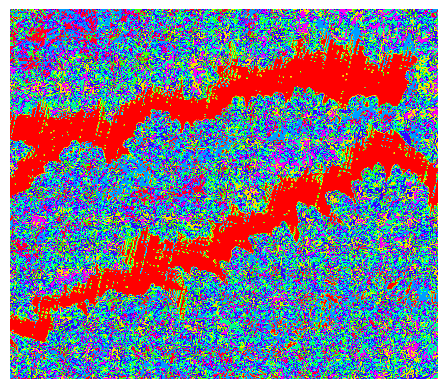

In [ ]:
plt.axis('off')
plt.imshow(X_cluster, cmap="hsv")

What about using all 4 bands of LISS-3?

In [ ]:
img_ds = gdal.Open('liss3-panshet.tif')
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print (img.shape)

print (new_shape)

X = img[:, :, :13].reshape(new_shape)

print (X.shape)

(384, 444, 4)
(170496, 4)
(170496, 4)


Now fit it

In [ ]:
k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)

X_cluster = k_means.labels_

X_cluster = X_cluster.reshape(img[:, :, 0].shape)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


And plot

(384, 444)


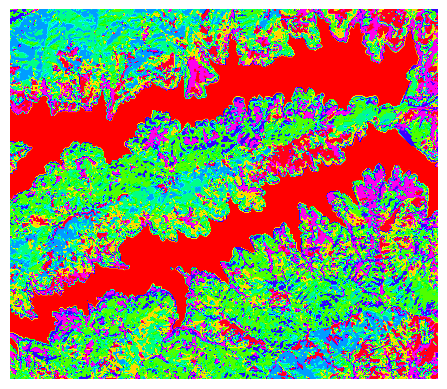

In [ ]:
print (X_cluster.shape)

plt.axis("off")
plt.imshow(X_cluster, cmap="hsv")

Changing the classification is straight forward. In this example choose MiniBatchKMeans


In [ ]:
MB_KMeans = cluster.MiniBatchKMeans(n_clusters=8)
MB_KMeans.fit(X)

X_cluster = MB_KMeans.labels_

X_cluster = X_cluster.reshape(img[:, :, 0].shape)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Plot the result


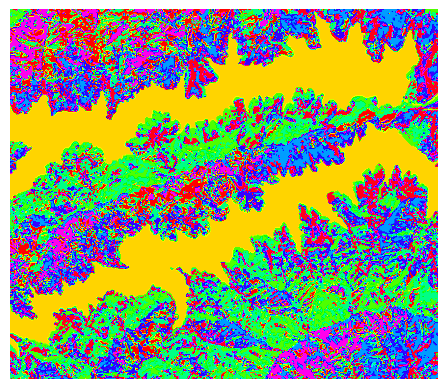

In [ ]:
plt.axis("off")
plt.imshow(X_cluster, cmap="hsv")

# Supervised classification

We shall now use the pre-prepared landcover data as labels for our supervised classification



> To prepare the training data in GIS software:
1. Prepare ROI polygons containing landcover codes
2. Rasterize the ROI to same dimensions as that of input FCC / MSS image

(384, 444)


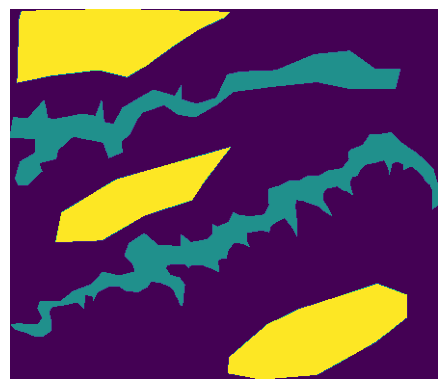

In [ ]:
# displaying the landcover used in this exercise
lcover = gdal.Open('landcover.tif').ReadAsArray()
print(lcover.shape)
plt.axis('off')
plt.imshow(lcover)

Reshaping the LISS image to create features and samples

In [ ]:
l3 = gdal.Open('liss3-panshet.tif').ReadAsArray()
X = l3.flatten('F').reshape([-1, 4]) # for 4 band data
print(X.shape)

(170496, 4)


Reshaping the landcover to labels

In [ ]:
y = lcover.flatten('F')
print(y.shape)

(170496,)


Fitting a DT model on the data prepared.

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 70% training and 30% test

#Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7717257424387574


Train the model using the concept of cross validation

In [ ]:
print('Accuracy with cross validation set to 3')
print(cross_val_score(clf, X_train, y_train, cv=3))

Accuracy with cross validation set to 3
[0.76522635 0.76343572 0.76275703]


Predicting for all pixels and making an predicted LC map

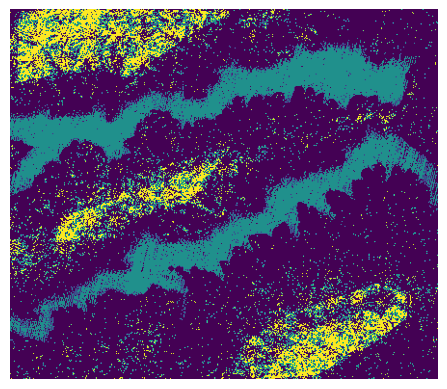

In [ ]:
predicted_lc = clf.predict(X).reshape(lcover.shape, order='F')
plt.axis('off')
plt.imshow(predicted_lc)

# Hyper-parameter tuning

DT has several hyper-parameters we can tune such as criterion, splitter, max_depth, min_samples_split, etc.


In [ ]:
# let us try experimenting with the 2 criterion 'gini' and 'entropy'
criteria = ['gini', 'entropy']

for each_criteria in criteria:
    #Create a Decision Tree Classifier
    clf = DecisionTreeClassifier(criterion = each_criteria, random_state=0)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("Accuracy with", each_criteria, 'criterion = ', metrics.accuracy_score(y_test, y_pred))

Accuracy with gini criterion =  0.7717257424387574
Accuracy with entropy criterion =  0.7709241627402296


Let us try experimenting with the max_depth hyper-parameter


In [ ]:
max_depth = range(3, 10)

for depth in max_depth:
    #Create a Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth = depth, random_state=0)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("Accuracy with", each_criteria, 'depth = ', metrics.accuracy_score(y_test, y_pred))

Accuracy with entropy depth =  0.7925863653248353
Accuracy with entropy depth =  0.8002306985473812
Accuracy with entropy depth =  0.8002306985473812
Accuracy with entropy depth =  0.8000938434769008
Accuracy with entropy depth =  0.8008172202780113
Accuracy with entropy depth =  0.8020489159123345
Accuracy with entropy depth =  0.8034565680658469


We see that the accuracies are increasing. Let us plot our results with more depth values


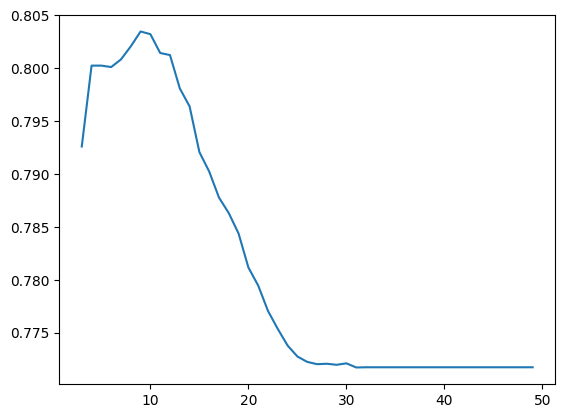

In [ ]:
max_depth = range(3, 50)
acc = []

for depth in max_depth:
    #Create a Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth = depth, random_state=0)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(max_depth, acc)